# dl

> Deep learning based operators

In [ ]:
#| default_exp dl

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
from numba import prange
import onnxruntime
import importlib
import math
import random
import moraine as mr
from moraine.utils_ import ngjit, ngpjit
from moraine.utils_ import is_cuda_available, get_array_module
from moraine.chunk_ import chunkwise_slicing_mapping
if is_cuda_available():
    import cupy as cp

In [ ]:
#| hide
import zarr

In [ ]:
#| export
def _ort_session(
    path:str, # path to the model in onnx format
    cuda:bool=False, # if use cuda or not
):
    if cuda:
        import cupy as cp
        providers = [("CUDAExecutionProvider", {"device_id": cp.cuda.runtime.getDevice()}),'CPUExecutionProvider']
    else:
        providers = ['CPUExecutionProvider']
    ort_session = onnxruntime.InferenceSession(path, providers=providers)
    return ort_session

In [ ]:
#| export
@ngpjit
def _pre_infer_n2f_numba(intf):
    nlines, width = intf.shape
    out = np.empty((1,2,nlines,width),dtype=np.float32)
    mask = np.empty((nlines,width),dtype=np.bool_)
    for i in prange(nlines):
        for j in prange(width):
            intf_i_j = intf[i,j]
            if math.isnan(intf_i_j.real):
                mask[i,j] = True
                random_phase = random.uniform(-math.pi,math.pi)
                out[0,0,i,j] = math.cos(random_phase)
                out[0,1,i,j] = math.sin(random_phase)
            else:
                mask[i,j] = False
                amp = abs(intf_i_j)
                out[0,0,i,j] = intf_i_j.real/amp
                out[0,1,i,j] = intf_i_j.imag/amp
    return out, mask

In [ ]:
#| export
if is_cuda_available():
    _pre_infer_n2f_kernel = cp.ElementwiseKernel(
            'raw T intf, int32 nlines, int32 width',
            'raw float32 out, raw bool mask',
            '''
            int npixels = nlines*width;
            if (i >= npixels) return;

            //int az = i/width;
            //int r = i-az*width;
            T intf_i = intf[i];
            if (isnan(intf_i.real())){
                mask[i] = true;
            }
            else{
                mask[i] = false;
                float amp = abs(intf_i);
                out[i] = intf_i.real()/amp;
                out[npixels+i] = intf_i.imag()/amp;
            }
            ''',
            #preamble = '#include "curand.h"',
            # I do not find an easy way to generate random number with cupy kernel
            name = 'pre_infer_n2f_kernel',no_return=True)

In [ ]:
#| export
if is_cuda_available():
    def _pre_infer_n2f_cp(intf):
        nlines, width = intf.shape
        out = cp.empty((1,2,nlines,width),dtype=cp.float32)
        mask = cp.empty((nlines,width),dtype=cp.bool_)
        _pre_infer_n2f_kernel(intf,cp.int32(nlines),cp.int32(width),out,mask,size=nlines*width,block_size=128)
        nan_pos = cp.where(mask)
        random_phase = cp.random.uniform(-cp.pi,cp.pi,len(nan_pos[0]))
        out[0,0,nan_pos[0],nan_pos[1]] = cp.cos(random_phase)
        out[0,1,nan_pos[0],nan_pos[1]] = cp.sin(random_phase)
        return out, mask

In [ ]:
#| hide
rslc_zarr = zarr.open('../CLI/raw/rslc.zarr/','r')
test_img_complex = rslc_zarr[:,:,0]*rslc_zarr[:,:,1].conj()

In [ ]:
#| hide
intf, mask = _pre_infer_n2f_numba(test_img_complex)
intf_ = test_img_complex*(1/abs(test_img_complex))
intf_ = np.stack((intf_.real,intf_.imag))[None,...]
np.testing.assert_array_almost_equal(intf[:,:,~mask],intf_[:,:,~mask])

In [ ]:
#| hide
if is_cuda_available():
    intf_cp, mask_cp = _pre_infer_n2f_cp(cp.asarray(test_img_complex))
    np.testing.assert_array_almost_equal(intf[:,:,~mask],intf_cp[:,:,~mask_cp].get())
    np.testing.assert_array_equal(mask,mask_cp.get())

In [ ]:
#| export
@ngpjit
def _after_infer_n2f_numba(
    infer_out,
    mask,
):
    nlines, width = mask.shape
    out = np.empty((nlines,width),dtype=np.complex64)
    for i in prange(nlines):
        for j in prange(width):
            if mask[i,j]:
                out[i,j] = np.nan+1j*np.nan
            else:
                out[i,j] = infer_out[0,0,i,j]+1j*infer_out[0,1,i,j]
    return out

In [ ]:
#| export
if is_cuda_available():
    _after_infer_n2f_kernel = cp.ElementwiseKernel(
            'raw float32 infer_out, raw bool mask, int32 nlines, int32 width',
            'raw T out',
            '''
            int npixels = nlines*width;
            if (i >= npixels) return;

            if (mask[i]){
                out[i] = T(CUDART_NAN,CUDART_NAN);
            }
            else{
                out[i] = T(infer_out[i],infer_out[npixels+i]);
            }
            ''',
            preamble = '#include <cupy/math_constants.h>',
            name = 'after_infer_n2f_kernel',no_return=True)

In [ ]:
#| export
if is_cuda_available():
    def _after_infer_n2f_cp(infer_out,mask):
        nlines, width = mask.shape
        out = cp.empty((nlines,width),dtype=cp.complex64)
        _after_infer_n2f_kernel(infer_out,mask,cp.int32(nlines),cp.int32(width),out,size=nlines*width,block_size=128)
        return out

In [ ]:
#| hide
rslc_zarr = zarr.open('../CLI/raw/rslc.zarr/','r')
test_img_complex = rslc_zarr[:,:,2]*rslc_zarr[:,:,14].conj()

In [ ]:
#| hide
intf, mask = _pre_infer_n2f_numba(test_img_complex)
out = _after_infer_n2f_numba(intf,mask)
np.testing.assert_array_almost_equal(np.angle(test_img_complex),np.angle(out))

In [ ]:
#| hide
if is_cuda_available():
    out_cp = _after_infer_n2f_cp(cp.asarray(intf),cp.asarray(mask))
    np.testing.assert_array_almost_equal(np.angle(test_img_complex),np.angle(out_cp.get()))

In [ ]:
#| hide
if is_cuda_available():
    intf_cp, mask_cp = _pre_infer_n2f_cp(cp.asarray(test_img_complex))
    np.testing.assert_array_almost_equal(intf[:,:,~mask],intf_cp[:,:,~mask_cp].get())
    np.testing.assert_array_equal(mask,mask_cp.get())

In [ ]:
#| export
def _infer_n2f_cpu(
    intf,
    session,
):
    input_intf, mask = _pre_infer_n2f_numba(intf)
    infer_out = session.run([session.get_outputs()[0].name,],{session.get_inputs()[0].name: input_intf})[0]
    return _after_infer_n2f_numba(infer_out,mask)

In [ ]:
#| export
def _infer_n2f_gpu(
    intf,
    session,
):
    input_intf, mask = _pre_infer_n2f_cp(intf)
    input_intf = cp.ascontiguousarray(input_intf)
    out = cp.ascontiguousarray(cp.empty_like(input_intf))
    io_binding = session.io_binding()
    io_binding.bind_input(
            name=session.get_inputs()[0].name,
            device_type='cuda',
            device_id=input_intf.device.id,
            element_type=input_intf.dtype,
            shape=list(input_intf.shape),
            buffer_ptr=input_intf.data.ptr,
    )
    io_binding.bind_output(
            name=session.get_outputs()[0].name,
            device_type='cuda',
            device_id=out.device.id,
            element_type=out.dtype,
            shape=list(out.shape),
            buffer_ptr=out.data.ptr,
    )
    io_binding.synchronize_inputs()
    session.run_with_iobinding(io_binding)
    return _after_infer_n2f_cp(out,mask)

In [ ]:
#| export
def n2f(
    intf:np.ndarray, # interferogram, 2d np.complex64 or cp.complex64
    chunks:tuple=None, # chunksize, intf.shape by default 
    depths:tuple=(0,0), # width of the boundary
    model:str=None, # path to the model in onnx format, use the model comes with this package by default
):
    xp = mr.utils_.get_array_module(intf)
    if model is None:
        model = importlib.resources.files('moraine')/'dl_model/n2f.onnx'
    shape = intf.shape
    if chunks is None: chunks = shape
    in_slices, out_slices, map_slices = chunkwise_slicing_mapping(shape,chunks,depths)
    out = xp.empty_like(intf)

    if xp is np:
        session = _ort_session(model,cuda=False)
        for in_slice, out_slice, map_slice in zip(in_slices, out_slices, map_slices):
            out[out_slice] = _infer_n2f_cpu(intf[in_slice],session)[map_slice]
    else:
        session = _ort_session(model,cuda=True)
        for in_slice, out_slice, map_slice in zip(in_slices, out_slices, map_slices):
            out[out_slice] = _infer_n2f_gpu(intf[in_slice],session)[map_slice]

    return out

Usage:

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
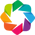

In [ ]:
import zarr
import numpy as np
import holoviews as hv
hv.extension('bokeh')
hv.output(widget_location='bottom')
from bokeh.models import WheelZoomTool
from holoviews import opts

In [ ]:
rslc_zarr = zarr.open('../CLI/raw/rslc.zarr/','r')
intf = rslc_zarr[:,:,7]*rslc_zarr[:,:,13].conj()

In [ ]:
%%time
filtered_intf = n2f(intf)

CPU times: user 3min 50s, sys: 49.6 s, total: 4min 39s
Wall time: 4.61 s


In [ ]:
if is_cuda_available():
    intf_cp = cp.asarray(intf)

In [ ]:
%%time
if is_cuda_available():
    filtered_intf_cp = n2f(intf_cp)

CPU times: user 4.58 s, sys: 1.44 s, total: 6.02 s
Wall time: 6.41 s


In [ ]:
raw_intf_plot = mr.ras_plot(np.angle(intf))
filtered_intf_plot = mr.ras_plot(np.angle(filtered_intf))
(raw_intf_plot+filtered_intf_plot).opts(
    opts.Image(
        cmap='colorwheel',width=600, height=600, colorbar=True,invert_yaxis=True,
        default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
        active_tools=['wheel_zoom'])
)

:Layout
   .DynamicMap.I  :DynamicMap   []
      :Image   [x,y]   (z)
   .DynamicMap.II :DynamicMap   []
      :Image   [x,y]   (z)

In [ ]:
#| hide
if is_cuda_available():
    raw_intf_plot = mr.ras_plot(np.angle(intf))
    filtered_intf_plot = mr.ras_plot(np.angle(filtered_intf_cp.get()))
(raw_intf_plot+filtered_intf_plot).opts(
    opts.Image(
        cmap='colorwheel',width=600, height=600, colorbar=True,invert_yaxis=True,
        default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
        active_tools=['wheel_zoom'])
)

:Layout
   .DynamicMap.I  :DynamicMap   []
      :Image   [x,y]   (z)
   .DynamicMap.II :DynamicMap   []
      :Image   [x,y]   (z)

In [ ]:
#| hide
np.testing.assert_array_equal(np.isnan(intf),np.isnan(filtered_intf))
np.testing.assert_array_equal(np.isnan(filtered_intf_cp.get()),np.isnan(filtered_intf))
# filtered_intf at some pixels between cpu one and gpu one can be very different

In [ ]:
#| export
def _n2f_np_in_gpu(
    intf:np.ndarray, # interferogram, 2d np.complex64 or cp.complex64
    chunks:tuple=None, # chunksize, intf.shape by default 
    depths:tuple=(0,0), # width of the boundary
    model:str=None, # path to the model in onnx format, use the model comes with this package by default
):
    '''compare with n2f, input and output are np.ndarray but use gpu for inference'''
    if model is None:
        model = importlib.resources.files('moraine')/'dl_model/n2f.onnx'
    shape = intf.shape
    if chunks is None: chunks = shape
    in_slices, out_slices, map_slices = chunkwise_slicing_mapping(shape,chunks,depths)
    out = np.empty_like(intf)

    session = _ort_session(model,cuda=True)
    for in_slice, out_slice, map_slice in zip(in_slices, out_slices, map_slices):
        out[out_slice] = _infer_n2f_gpu(cp.asarray(intf[in_slice]),session)[map_slice].get()
    return out

In [ ]:
if is_cuda_available():
    filtered_intf_ = _n2f_np_in_gpu(intf)
    raw_intf_plot = mr.ras_plot(np.angle(intf))
    filtered_intf_plot = mr.ras_plot(np.angle(filtered_intf_))
(raw_intf_plot+filtered_intf_plot).opts(
        opts.Image(
            cmap='colorwheel',width=600, height=600, colorbar=True,invert_yaxis=True,
            default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
            active_tools=['wheel_zoom'])
)

:Layout
   .DynamicMap.I  :DynamicMap   []
      :Image   [x,y]   (z)
   .DynamicMap.II :DynamicMap   []
      :Image   [x,y]   (z)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()